In [39]:
import matplotlib.pyplot as plt
import numpy as np

class QuickSort(object):
    "Quick Sort to get medium number"

    def __init__(self, low, high, array):
        self._array = array
        self._low = low
        self._high = high
        self._medium = (low+high+1)//2 # python3中的整除

    def get_medium_num(self):
        return self.quick_sort_for_medium(self._low, self._high, 
                                          self._medium, self._array)

    def quick_sort_for_medium(self, low, high, medium, array): #用快速排序来获取中位数
        if high == low:
            return array[low] # find medium
        if high > low:
            index, partition = self.sort_partition(low, high, array); 
            #print array[low:index], partition, array[index+1:high+1]
            if index == medium:
                return partition
            if index > medium:
                return self.quick_sort_for_medium(low, index-1, medium, array)
            else:
                return self.quick_sort_for_medium(index+1, high, medium, array)

    def quick_sort(self, low, high, array):  #正常的快排
        if high > low:
            index, partition = self.sort_partition(low, high, array); 
            #print array[low:index], partition, array[index+1:high+1]
            self.quick_sort(low, index-1, array)
            self.quick_sort(index+1, high, array)

    def sort_partition(self, low, high, array): # 用第一个数将数组里面的数分成两部分
        index_i = low
        index_j = high
        partition = array[low]
        while index_i < index_j:
            while (index_i < index_j) and (array[index_j] >= partition):
                index_j -= 1
            if index_i < index_j:
                array[index_i] = array[index_j]
                index_i += 1
            while (index_i < index_j) and (array[index_i] < partition):
                index_i += 1
            if index_i < index_j:
                array[index_j] = array[index_i]
                index_j -= 1
        array[index_i] = partition
        return index_i, partition

## KD Tree Construction

In [40]:
class KDTree(object):

    def __init__(self, input_x, input_y):
        self._input_x = np.array(input_x)
        self._input_y = np.array(input_y)
        (data_num, axes_num) = np.shape(self._input_x)
        self._data_num = data_num
        self._axes_num = axes_num
        self._nearest = None  #用来存储最近的节点
        return

    def construct_kd_tree(self):
        return self._construct_kd_tree(0, 0, self._input_x)

    def _construct_kd_tree(self, depth, axes, data):
        if not data.any():
            return None
        axes_data = data[:, axes].copy()
        qs = QuickSort(0, axes_data.shape[0]-1, axes_data)
        medium = qs.get_medium_num() #找到轴的中位数

        data_list = []
        left_data = []
        right_data = []
        data_range = range(np.shape(data)[0])
        for i in data_range:   # 跟中位数相比较
            if data[i][axes] == medium:  #相等
                data_list.append(data[i])
            elif data[i][axes] < medium: 
                left_data.append(data[i])
            else:
                right_data.append(data[i])

        left_data = np.array(left_data)
        right_data = np.array(right_data)
        left = self._construct_kd_tree(depth+1, (axes+1)% self._axes_num, left_data)
        right = self._construct_kd_tree(depth+1, (axes+1)% self._axes_num, right_data)
        #[树的深度，轴，中位数，该节点的数据，左子树，右子树]
        root = [depth, axes, medium, data_list, left, right] 
        return root

    def print_kd_tree(self, root): #打印kd树
        if root:
            [depth, axes, medium, data_list, left, right] = root
            print('{} {}'.format('    '*depth, data_list[0]))
            if root[4]:
                self.print_kd_tree(root[4])
            if root[5]:
                self.print_kd_tree(root[5])
    def _get_distance(self, x1, x2): #计算两个向量之间的距离
        x = x1-x2
        return np.sqrt(np.inner(x, x))

    def _search_leaf(self, stack, tree, target): #以tree为根节点，一直搜索到叶节点，并添加到stack中
        travel_tree = tree
        while travel_tree:
            [depth, axes, medium, data_list, left, right] = travel_tree
            if target[axes] >= medium:
                next_node = right
                next_direction = 'right' # 记录被访问过的子树的方向
            elif target[axes] < medium:
                next_node = left
                next_direction = 'left' # 记录被访问过的子树的方向
            stack.append([travel_tree, next_direction]) #保存方向，用来记录哪个子树被访问过
            travel_tree = next_node

    def _check_nearest(self, current, target): # 判断当前节点跟目标的距离
        d = self._get_distance(current, target)
        if self._nearest:
            [node, distance] = self._nearest
            if d < distance:
                self._nearest = [current, d]
        else:
            self._nearest = [current, d]

    def search_kd_tree(self, tree, target): #搜索kd树
        stack = []
        self._search_leaf(stack, tree, target) # 一直搜索到叶节点，并将路径入栈
        self._nearest = []
        while stack:
            [[depth, axes, medium, data_list, left, right], next_direction] = stack.pop() #出栈
            [data] = data_list
            self._check_nearest(data, target) #检查当前节点的距离

            if left is None and right is None: #如果当前节点为叶节点，继续下一个循环
                continue
            [node, distance] = self._nearest
            if abs(data[axes] - node[axes]) < distance: #<*> 当前节点的轴经过圆
                if next_direction == 'right': # 判断哪个方向被访问过，转向相反方向
                    try_node = left
                else:
                    try_node = right
                self._search_leaf(stack, try_node, target) #往相反的方向搜索叶节点
        print(self._nearest)

        def _check_nearest(self, current, target, k):
            d = self._get_distance(current, target)
            #print current, d
            l = len(self._nearest)
            if l < k:
                self._nearest.append([current, d])
            else:
                farthest = self._get_farthest()[1]
                if farthest > d:
                    # 将最远的节点移除
                    new_nearest = [i for i in self._nearest if i[1]<farthest ]
                    new_nearest.append([current, d])
                self._nearest = new_nearest

        def _get_farthest(self): #获取list中最远的节点
            farthest = None
            for i in self._nearest:
                if not farthest:
                    farthest = i
                else:
                    if farthest[1] < i[1]:
                        farthest = i
            return farthest

## 测试

In [41]:
input_x = [[2,3], [5,4], [9,6], [4,7], [8,1], [7,2]]
input_y = [1, 1, 1, 1, 1, 1]
kd = KDTree(input_x, input_y)
tree = kd.construct_kd_tree()
kd.print_kd_tree(tree)

 [7 2]
     [5 4]
         [2 3]
         [4 7]
     [9 6]
         [8 1]


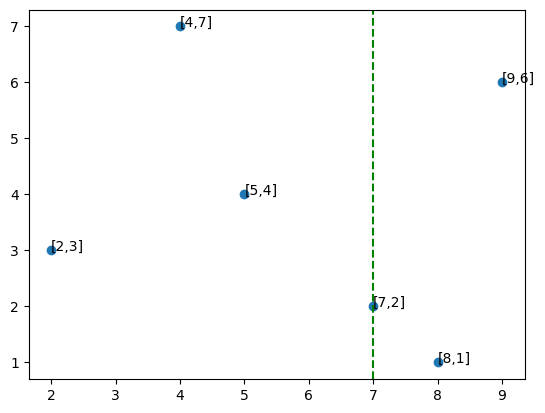

In [47]:
#绘制样本点的散点分布图
x = np.array([2, 5, 9, 4, 8, 7])
y = np.array([3, 4, 6, 7, 1, 2])

labels = ['[2,3]', '[5,4]', '[9,6]', '[4,7]', '[8,1]','[7,2]'] 

plt.figure() # 新建一个绘图

# 为各个点添加标签  
for i in range(len(labels)):  
    plt.annotate(labels[i], (x[i], y[i])) 

plt.scatter(x, y)

#添加空间划分线
plt.axvline(x=7, label='x = 7', color='green', linestyle='--')


plt.show()


In [43]:
kd.search_kd_tree(tree,[4,7])

[array([4, 7]), 0.0]
